## Importing Libraries

In [44]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np
import imageio
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Loading MNIST dataset

In [3]:
(train_x, train_y),(test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Basic Preprocessing

In [4]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
train_x = train_x/255.0
test_x = test_x/255.0

## Keras NN model for MNIST

In [50]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape = (28, 28, 1), name='conv_1'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3), name='conv_2'))
model.add(BatchNormalization(name='batch_norm_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool_1'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax', name='dense_2'))

model.compile(loss= 'categorical_crossentropy' , optimizer= keras.optimizers.Adadelta(), metrics=['accuracy'])

### Training the model

In [51]:
train = model.fit(train_x, keras.utils.to_categorical(train_y), batch_size=128, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 112us/step - loss: 0.7929 - acc: 0.7686 - val_loss: 0.2071 - val_acc: 0.9395
Epoch 2/10
48000/48000 [==============================] - 4s 82us/step - loss: 0.3188 - acc: 0.9059 - val_loss: 0.1201 - val_acc: 0.9670
Epoch 3/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.2097 - acc: 0.9385 - val_loss: 0.0943 - val_acc: 0.9757
Epoch 4/10
48000/48000 [==============================] - 4s 82us/step - loss: 0.1643 - acc: 0.9513 - val_loss: 0.0914 - val_acc: 0.9772
Epoch 5/10
48000/48000 [==============================] - 4s 83us/step - loss: 0.1370 - acc: 0.9597 - val_loss: 0.0691 - val_acc: 0.9824
Epoch 6/10
48000/48000 [==============================] - 4s 84us/step - loss: 0.1172 - acc: 0.9654 - val_loss: 0.0704 - val_acc: 0.9831
Epoch 7/10
48000/48000 [==============================] - 4s 82us/step - loss: 0.1031 - acc: 0.9685 - val_loss: 0.0844 - val_ac

### Saving the weights after training

In [52]:
model.save_weights('weights.h5')

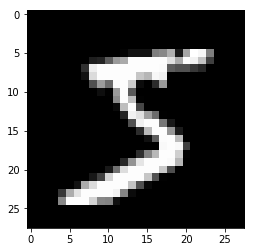

In [53]:
plt.imshow(train_x[0].reshape(28, 28),cmap='gray', vmin=0, vmax=1 )

## Loading the Devanagari dataset using ImageDataGenerator

In [54]:
datagen = ImageDataGenerator(
    rescale = 1. /255,
    data_format = 'channels_last')

train_generator = datagen.flow_from_directory('../input/numeral-preprocessed/numeral/Numeral/train/',
                                                   target_size = (28,28),
                                                   batch_size = 8,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

valid_generator = datagen.flow_from_directory('../input/numeral-preprocessed/numeral/Numeral/valid/',
                                                   target_size = (28,28),
                                                   batch_size = 8,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

test_generator = datagen.flow_from_directory('../input/numeral-preprocessed/numeral/Numeral/test/',
                                            target_size = (28,28),
                                            batch_size = 8,
                                            color_mode = 'grayscale')

Found 104 images belonging to 10 classes.
Found 28 images belonging to 10 classes.
Found 30 images belonging to 10 classes.


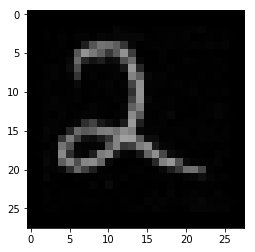

In [55]:
plt.imshow(train_generator[0][0][0].reshape(28,28), cmap='gray', vmin=0, vmax=1)

In [56]:
train_generator[0][0].shape

(8, 28, 28, 1)

## New NN model for Devanagari digit classification

In [62]:
new_model = Sequential()

new_model.add(Conv2D(32, kernel_size=(3,3), input_shape = (28, 28, 1), name='conv_1', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_1', trainable= False))

new_model.add(Conv2D(64, (3,3), name='conv_2', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_2', trainable= False))
new_model.add(MaxPooling2D(pool_size=(2,2), name='max_pool_1', trainable= False))

new_model.add(Flatten())
new_model.add(Dense(128, activation='relu', name='dense_1', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_3', trainable= False))

new_model.add(Dense(10, activation='softmax', name='dense_2'))

new_model.compile(loss= 'categorical_crossentropy' , optimizer= keras.optimizers.Adadelta(), metrics=['accuracy'])

## Loading the same weights from the MNIST classifier NN model

In [63]:
new_model.load_weights('weights.h5', by_name=True)

In [64]:
print(test_generator[1][0][6].shape)

(28, 28, 1)


### Predicting without training the new model

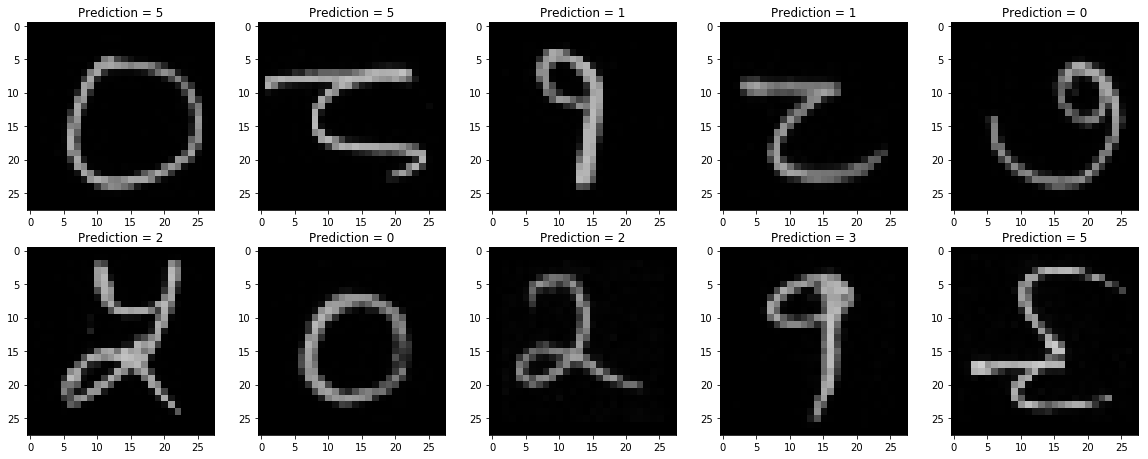

In [65]:
fig = plt.figure(figsize=(20,20))
plot_index = 1
for i in range(2):
    for j in range(1,6):
        fig.add_subplot(5,5,plot_index)
        train_pred = new_model.predict(np.expand_dims(test_generator[i][0][j-1],0))
        plt.title("Prediction = " + str(np.argmax(train_pred)))
        plt.imshow(test_generator[i][0][j-1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
        plot_index += 1
plt.show()

## Training the new model

In [66]:
#es = EarlyStopping(monitor='val_acc', mode='auto', patience=5)
#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, min_lr=0.001, patience=5)

new_model.fit_generator(train_generator,
                       validation_data = valid_generator,
                       validation_steps = 16,
                       epochs = 50,
                       steps_per_epoch = 16)

Epoch 1/50
16/16 [==============================] - 2s 97ms/step - loss: 3.4908 - acc: 0.2500 - val_loss: 4.8867 - val_acc: 0.2857
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 3.1099 - acc: 0.2891 - val_loss: 4.5857 - val_acc: 0.3036
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 2.7845 - acc: 0.3281 - val_loss: 3.6887 - val_acc: 0.3214
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 2.3712 - acc: 0.2500 - val_loss: 3.0230 - val_acc: 0.3304
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.9924 - acc: 0.3828 - val_loss: 2.5993 - val_acc: 0.3929
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7139 - acc: 0.4688 - val_loss: 2.3402 - val_acc: 0.4464
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6771 - acc: 0.4375 - val_loss: 1.9693 - val_acc: 0.5804
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.2086 - a

## Predicting with the new model

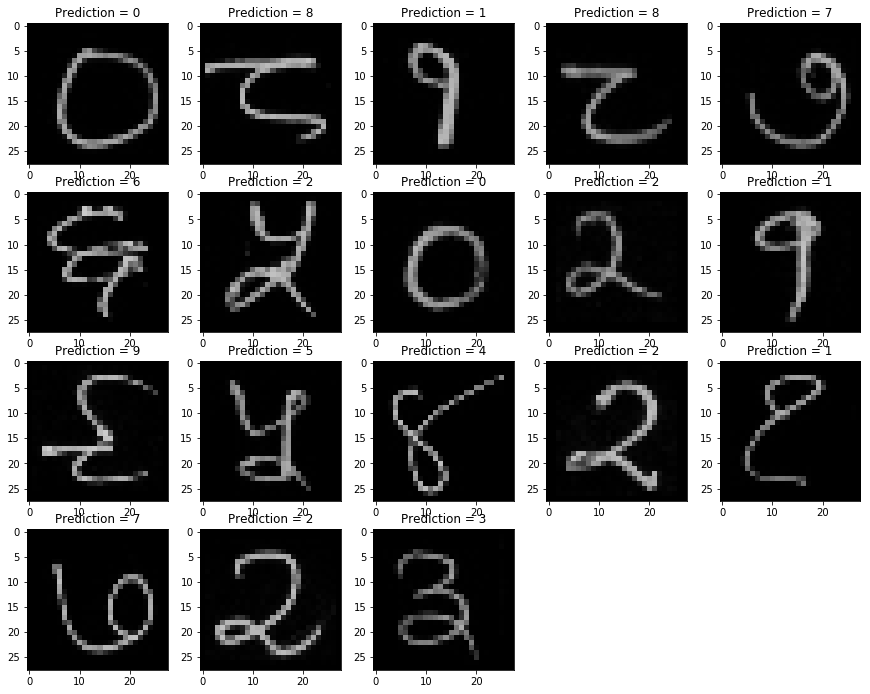

In [67]:
fig = plt.figure(figsize=(15,15))
plot_index = 1
for i in range(3):
    for j in range(1,7):
        fig.add_subplot(5,5,plot_index)
        train_pred = new_model.predict(np.expand_dims(test_generator[i][0][j-1],0))
        plt.title("Prediction = " + str(np.argmax(train_pred)))
        plt.imshow(test_generator[i][0][j-1].reshape(28,28), cmap='gray', vmin=0, vmax=1)
        plot_index += 1
plt.show()